In [158]:
#pip install ee

In [159]:
#pip install geemap

# Import Libraries

In [160]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [161]:
lake = ee.FeatureCollection('projects/ee-touheda-khanom/assets/samplinglakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Big Moose Lake'))

station = ee.Geometry.Point(-74.85423940003443,43.81880036802749)
Map.addLayer(station)
Map.centerObject(station, 16)

Map.addLayer(lake)
Map.centerObject(lake, 16)
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [162]:
sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

In [163]:
def cdom(img):
    cdo = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b1': img.select('Aerosols'),
        'b2': img.select('Blue'),
        'b3': img.select('Green'),
        'b4': img.select('Red')
    }).rename("CO")
    
    bad2 = cdo.where(cdo.gte(0), 1).rename("bad2")
    co = cdo.multiply(bad2).rename("CO")
    mask = co.neq(0)

    return img.addBands(co).clip(lake).updateMask(mask)


# Masking Clouds

In [164]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage

s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(1,12, 'month')) \
    .filterBounds(station) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES) \
    .map(cdom)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 25)) 
    
    
#     .filter(ee.Filter.date('2019-09-17', '2019-09-19'))\
#     .filter(ee.Filter.calendarRange(15,20, 'day')) \


In [165]:
Map.addLayer(s2.first())
Map

Map(center=[43.83093869244275, -74.84826397158908], controls=(WidgetControl(options=['position', 'transparent_…

In [166]:
image = s2.toList(s2.size())
last_image = ee.Image(image.get(-1))
geemap.image_props(last_image).getInfo()

{'AOT_RETRIEVAL_ACCURACY': 0,
 'AOT_RETRIEVAL_METHOD': 'SEN2COR_DDV',
 'BOA_ADD_OFFSET_B1': -1000,
 'BOA_ADD_OFFSET_B10': -1000,
 'BOA_ADD_OFFSET_B11': -1000,
 'BOA_ADD_OFFSET_B12': -1000,
 'BOA_ADD_OFFSET_B2': -1000,
 'BOA_ADD_OFFSET_B3': -1000,
 'BOA_ADD_OFFSET_B4': -1000,
 'BOA_ADD_OFFSET_B5': -1000,
 'BOA_ADD_OFFSET_B6': -1000,
 'BOA_ADD_OFFSET_B7': -1000,
 'BOA_ADD_OFFSET_B8': -1000,
 'BOA_ADD_OFFSET_B8A': -1000,
 'BOA_ADD_OFFSET_B9': -1000,
 'CLOUDY_PIXEL_OVER_LAND_PERCENTAGE': 1.604859,
 'CLOUDY_PIXEL_PERCENTAGE': 1.841278,
 'CLOUD_COVERAGE_ASSESSMENT': 1.841278,
 'CLOUD_SHADOW_PERCENTAGE': 0.040046,
 'DARK_FEATURES_PERCENTAGE': 0.204661,
 'DATASTRIP_ID': 'S2B_OPER_MSI_L2A_DS_2BPS_20230530T200423_S20230530T155930_N05.09',
 'DATATAKE_IDENTIFIER': 'GS2B_20230530T154819_032541_N05.09',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0.0005,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1685477063000,
 'GEOMETRIC_QUALITY': 'PASSED'

In [167]:
#image = se.first()

In [168]:
imageFirst = s2.first()
geemap.image_props(imageFirst).getInfo()

{'AOT_RETRIEVAL_ACCURACY': 0,
 'CLOUDY_PIXEL_PERCENTAGE': 17.490407,
 'CLOUD_COVERAGE_ASSESSMENT': 17.490407,
 'CLOUD_SHADOW_PERCENTAGE': 1.797247,
 'DARK_FEATURES_PERCENTAGE': 0.573402,
 'DATASTRIP_ID': 'S2A_OPER_MSI_L2A_DS_SGS__20190615T195536_S20190615T155624_N02.12',
 'DATATAKE_IDENTIFIER': 'GS2A_20190615T154911_020786_N02.12',
 'DATATAKE_TYPE': 'INS-NOBS',
 'DEGRADED_MSI_DATA_PERCENTAGE': 0,
 'FORMAT_CORRECTNESS': 'PASSED',
 'GENERAL_QUALITY': 'PASSED',
 'GENERATION_TIME': 1560628536000,
 'GEOMETRIC_QUALITY': 'PASSED',
 'GRANULE_ID': 'L2A_T18TWP_A020786_20190615T155624',
 'HIGH_PROBA_CLOUDS_PERCENTAGE': 11.655708,
 'IMAGE_DATE': '2019-06-15',
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B1': 199.285898917,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B10': 200.999225339,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B11': 199.32133475,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B12': 198.435250802,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B2': 205.289363778,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B3': 202.860968058,
 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B4': 

In [169]:
print(s2.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'COPERNICUS/S2_SR', 'version': 1689700382224338, 'properties': {'date_range': [1490659200000, 1647907200000], 'period': 0, 'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['copernicus', 'esa', 'eu', 'msi', 'reflectance', 'sentinel', 'sr'], 'system:visualization_0_bands': 'B4,B3,B2', 'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png', 'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands representing SR scaled by 10000 (unlike in L1 d

In [170]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [171]:
vis_params = {'bands': ['Red', 'Green', 'Blue'], 'min': 0.0, 'max': 100.0, 'opacity': 1.0, 'gamma': 1.0}

In [172]:
 first_image = s2.first()  # Get the first image from the collection
band_names = first_image.bandNames().getInfo()
print("Band Names:", band_names)

Band Names: ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'CO']


In [173]:
#How many images?
print(s2.size().getInfo())


55


# CDOM

In [189]:
def station_mean(img): # station_mean function with a single parameter img
    #mean of a specific band (CO) within a region 
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('CDOM',mean)

station_reduced_imgs = s2.map(station_mean)
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','CDOM']).values().get(0)
df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])

df = pd.DataFrame(nested_list.getInfo(), columns=['date','CDOM'])
pd.set_option('display.max_rows', None)

df

,date,CDOM
0,2019-06-15T16:01:07,6.456487
1,2019-07-10T16:01:15,3.638376
2,2019-08-14T16:01:07,11.516527
3,2019-09-13T16:01:02,8.058640
4,2019-09-18T16:01:03,4.486538
5,2019-10-08T16:01:05,77.440000
6,2019-10-13T16:01:07,15.097324
7,2019-11-17T16:01:02,44986.410000
8,2020-03-01T16:00:59,7.695858
9,2020-03-16T16:01:02,7.536644


In [190]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,CDOM
0,2019-06-15,6.456487
1,2019-07-10,3.638376
2,2019-08-14,11.516527
3,2019-09-13,8.058640
4,2019-09-18,4.486538
5,2019-10-08,77.440000
6,2019-10-13,15.097324
7,2019-11-17,44986.410000
8,2020-03-01,7.695858
9,2020-03-16,7.536644


In [176]:
# import pandas as pd

# # Filter out CDOM values greater than 20
# df = df[df['CDOM'] <= 20]


# df

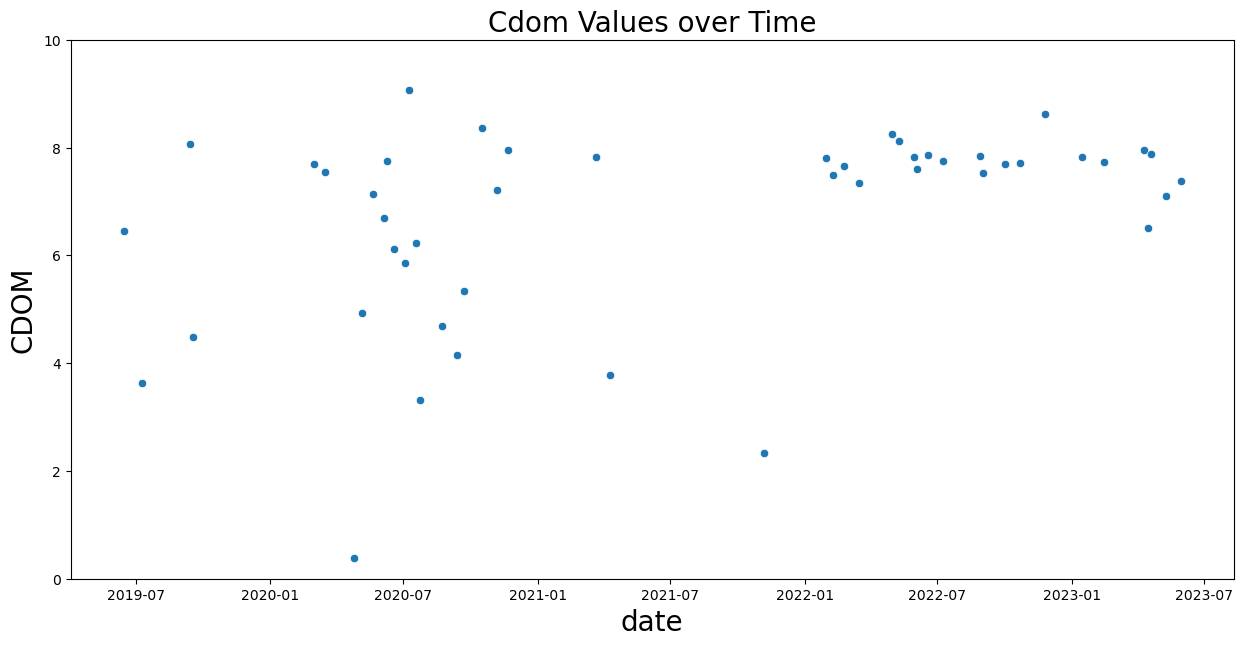

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time', fontsize=20)
ax.set_ylim(0,10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


# Reflectance Values

In [178]:
def reflectance(img): 
    #img is used to calculate the mean of specific bands indicated by STD_NAMES
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).select(STD_NAMES)
    return ee.Feature(None, {'date': img.date().format(), 'reflectance': reflectance_values})

s2_reflectance = s2.map(reflectance)
s2_list = s2_reflectance.reduceColumns(ee.Reducer.toList(2), ['date', 'reflectance']).values().get(0)
df_s2_reflectance = pd.DataFrame(s2_list.getInfo(), columns=['date', 'reflectance'])

# Convert date column to datetime and extract date only
df_s2_reflectance['date'] = pd.to_datetime(df_s2_reflectance['date']).dt.date

# Set the reflectance column values to a dictionary
df_s2_reflectance['reflectance'] = df_s2_reflectance['reflectance'].apply(lambda x: {k: v for k, v in x.items() if v is not None})
df_s2_reflectance

,date,reflectance
0,2019-06-15,"{'Aerosols': 353, 'Blue': 233, 'Green': 213, '..."
1,2019-07-10,"{'Aerosols': 654, 'Blue': 719, 'Green': 505, '..."
2,2019-08-14,"{'Aerosols': 499, 'Blue': 316, 'Green': 475, '..."
3,2019-09-13,"{'Aerosols': 184, 'Blue': 128, 'Green': 139, '..."
4,2019-09-18,"{'Aerosols': 77, 'Blue': 76, 'Green': 64, 'NIR..."
5,2019-10-08,"{'Aerosols': 18, 'Blue': 55, 'Green': 20, 'NIR..."
6,2019-10-13,"{'Aerosols': 17, 'Blue': 5, 'Green': 13, 'NIR'..."
7,2019-11-17,"{'Aerosols': 111, 'Blue': 46, 'Green': 2, 'NIR..."
8,2020-03-01,"{'Aerosols': 8631, 'Blue': 10079, 'Green': 981..."
9,2020-03-16,"{'Aerosols': 3062, 'Blue': 5307, 'Green': 5258..."


In [179]:
# Create empty lists to store the data
data = []

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    if reflectance:
        for band in STD_NAMES:
            value = reflectance.get(band)
            data.append({'Band': band, 'Reflectance': value, 'Date': date})

# Create a dataframe from the data
df_data = pd.DataFrame(data)

# Display the dataframe
print(df_data)



         Band  Reflectance        Date
0    Aerosols        353.0  2019-06-15
1        Blue        233.0  2019-06-15
2       Green        213.0  2019-06-15
3         Red        176.0  2019-06-15
4    RedEdge1        186.0  2019-06-15
5    RedEdge2        169.0  2019-06-15
6    RedEdge4        179.0  2019-06-15
7         NIR        200.0  2019-06-15
8       SWIR1        178.0  2019-06-15
9    Aerosols        654.0  2019-07-10
10       Blue        719.0  2019-07-10
11      Green        505.0  2019-07-10
12        Red        500.0  2019-07-10
13   RedEdge1        693.0  2019-07-10
14   RedEdge2       1263.0  2019-07-10
15   RedEdge4       1390.0  2019-07-10
16        NIR       1275.0  2019-07-10
17      SWIR1        841.0  2019-07-10
18   Aerosols        499.0  2019-08-14
19       Blue        316.0  2019-08-14
20      Green        475.0  2019-08-14
21        Red        535.0  2019-08-14
22   RedEdge1        592.0  2019-08-14
23   RedEdge2        722.0  2019-08-14
24   RedEdge4        716.

In [180]:
#Average band reflectance values for each month
data_by_month = {}

# Extract the bands, reflectance values, and dates where available
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'reflectance_values': {band: [] for band in STD_NAMES}}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['reflectance_values'][band].append(value)

# Calculate the average reflectance values for each band within each month
average_data = {'band': [], 'average_reflectance': []}

for month, data in data_by_month.items():
    for band, reflectance_values in data['reflectance_values'].items():
        if reflectance_values:  # Check if reflectance_values is not empty
            average_value = sum(reflectance_values) / len(reflectance_values)
            average_data['band'].append(band)
            average_data['average_reflectance'].append(average_value)

# Create a dataframe from the average data
df_average_data = pd.DataFrame(average_data)

# Display the dataframe
print(df_average_data)



        band  average_reflectance
0   Aerosols              0.03530
1       Blue              0.02330
2      Green              0.02130
3        Red              0.01760
4   RedEdge1              0.01860
5   RedEdge2              0.01690
6   RedEdge4              0.01790
7        NIR              0.02000
8      SWIR1              0.01780
9   Aerosols              0.06540
10      Blue              0.07190
11     Green              0.05050
12       Red              0.05000
13  RedEdge1              0.06930
14  RedEdge2              0.12630
15  RedEdge4              0.13900
16       NIR              0.12750
17     SWIR1              0.08410
18  Aerosols              0.04990
19      Blue              0.03160
20     Green              0.04750
21       Red              0.05350
22  RedEdge1              0.05920
23  RedEdge2              0.07220
24  RedEdge4              0.07160
25       NIR              0.05300
26     SWIR1              0.06470
27  Aerosols              0.01305
28      Blue  

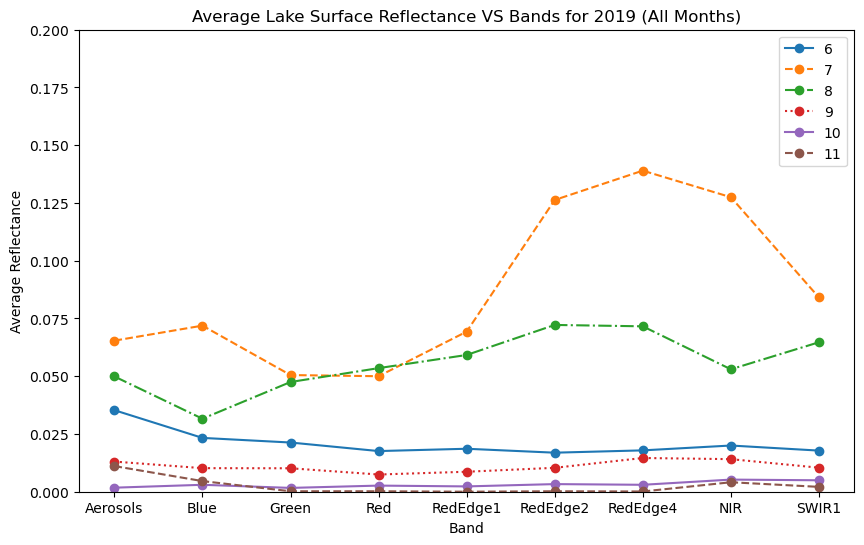

In [181]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['dates'].append(date)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in data_by_month.items():
    unique_dates = list(set(data['dates']))  # Get unique dates for the month
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    
    average_reflectance_values = []
    for band in STD_NAMES:
        reflectance_values = [data['reflectance'][i] for i in range(len(data['band'])) if data['band'][i] == band]
        
        if len(reflectance_values) > 0:
            average_reflectance = sum(reflectance_values) / len(reflectance_values)
            average_reflectance_values.append(average_reflectance)
        else:
            average_reflectance_values.append(0)
    
    plt.plot(STD_NAMES, average_reflectance_values, linestyle=line_style, marker='o', label=month)
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for 2019 (All Months)')
plt.legend()
plt.show()




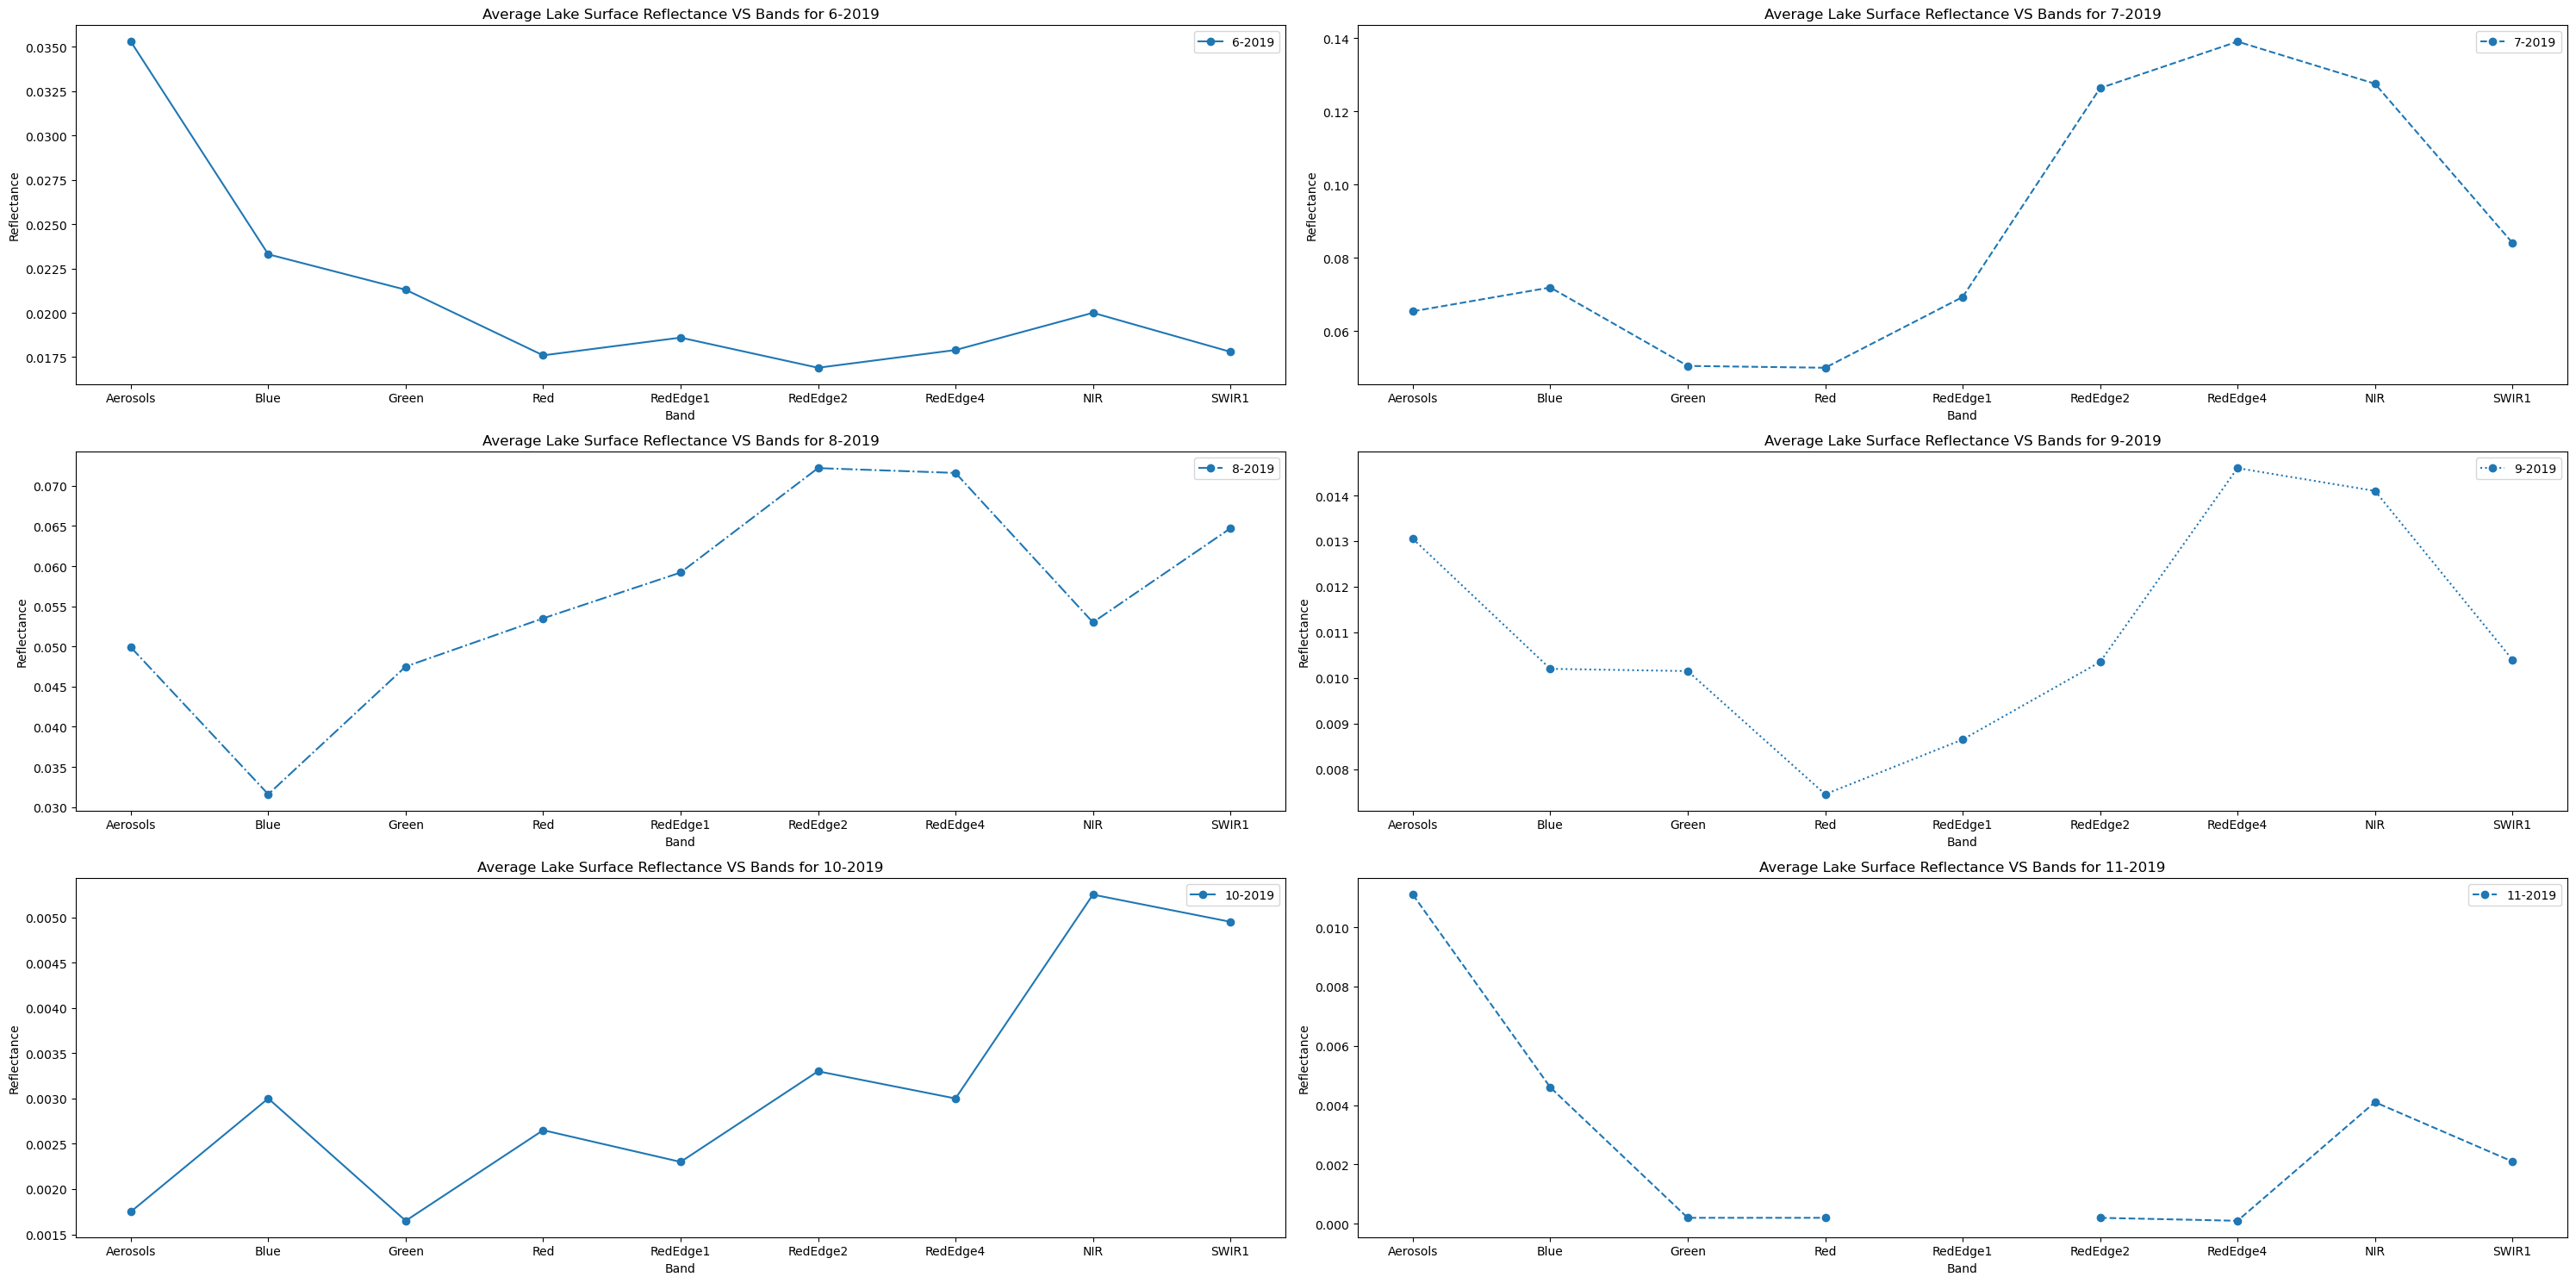

In [182]:
import numpy as np

data_by_month = {}

# Iterate over the dataframe rows
for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    # Filter data for specific months
    if year == 2019 and date.month in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        month = date.month
        
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)
                else:
                    data_by_month[month][band].append(np.nan)

# Calculate the average reflectance values for each band within each month
averages_by_month = {
    month: {band: np.nanmean(values) for band, values in data.items()}
    for month, data in data_by_month.items()
}

# Define plot parameters
line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)

# Calculate the number of rows and columns for the subplots
num_months = len(data_by_month)
num_cols = 2  # Number of subplots per row
num_rows = (num_months + num_cols - 1) // num_cols

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 5 * num_rows))

# Flatten the axs array to iterate over subplots
axs = axs.flatten()

# Iterate over the data for each month
for i, (month, data) in enumerate(averages_by_month.items()):
    line_style = line_styles[i % num_styles]  # Cycle through line styles
    
    axs[i].set_xlabel('Band')
    axs[i].set_ylabel('Reflectance')
    axs[i].set_title(f'Average Lake Surface Reflectance VS Bands for {month}-2019')
    
    bands = list(data.keys())
    reflectance_values = list(data.values())
    axs[i].plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}-2019')
    
    axs[i].legend()

plt.tight_layout()
plt.show()





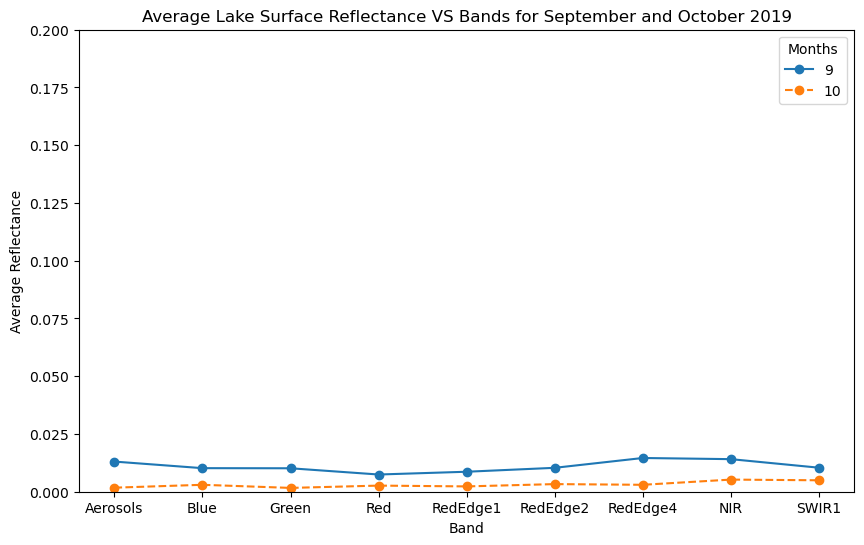

Data table for Month 9:
        band  reflectance
0   Aerosols       0.0184
1       Blue       0.0128
2      Green       0.0139
3        Red       0.0110
4   RedEdge1       0.0127
5   RedEdge2       0.0174
6   RedEdge4       0.0229
7        NIR       0.0223
8      SWIR1       0.0159
9   Aerosols       0.0077
10      Blue       0.0076
11     Green       0.0064
12       Red       0.0039
13  RedEdge1       0.0046
14  RedEdge2       0.0033
15  RedEdge4       0.0063
16       NIR       0.0059
17     SWIR1       0.0049

Data table for Month 10:
        band  reflectance
0   Aerosols       0.0018
1       Blue       0.0055
2      Green       0.0020
3        Red       0.0030
4   RedEdge1       0.0020
5   RedEdge2       0.0028
6   RedEdge4       0.0021
7        NIR       0.0017
8      SWIR1       0.0039
9   Aerosols       0.0017
10      Blue       0.0005
11     Green       0.0013
12       Red       0.0023
13  RedEdge1       0.0026
14  RedEdge2       0.0038
15  RedEdge4       0.0039
16       NIR  

In [183]:
data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month in [9, 10]:  # Filter for September (9) and October (10) only
        if month not in data_by_month:
            data_by_month[month] = {'band': [], 'reflectance': []}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month]['band'].append(band)
                    data_by_month[month]['reflectance'].append(value)

plt.figure(figsize=(10, 6))

line_styles = ['-', '--']  # List of line styles for two months
style_index = 0

for month, data in data_by_month.items():
    band_averages = {band: sum(data['reflectance'][i] for i, b in enumerate(data['band']) if b == band) / data['band'].count(band) for band in STD_NAMES}
    bands = list(band_averages.keys())
    reflectance_values = list(band_averages.values())
    
    line_style = line_styles[style_index]  # Cycle through line styles
    
    plt.plot(bands, reflectance_values, linestyle=line_style, marker='o', label=f'{month}')
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend(title='Months')
plt.show()

# Display the data table for September and October
for month, data in data_by_month.items():
    print(f"Data table for Month {month}:")
    df = pd.DataFrame(data)
    print(df)
    print()



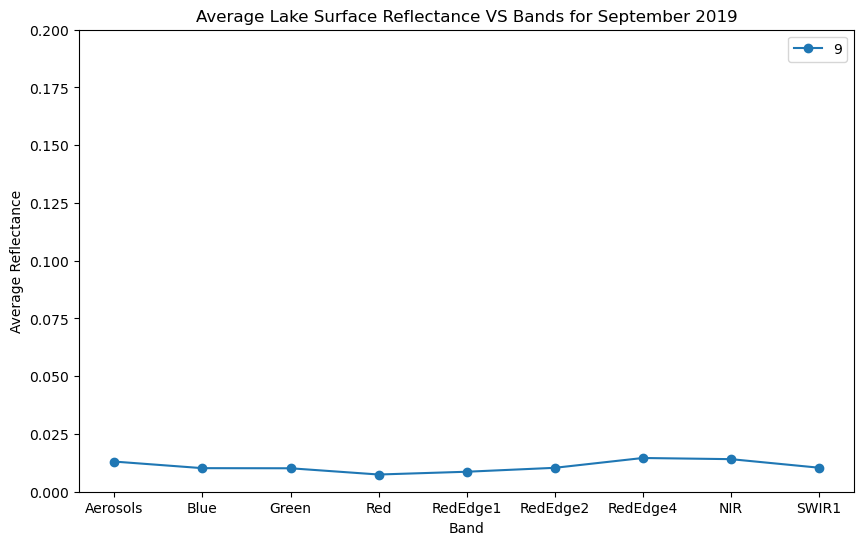

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded the data into df_s2_reflectance and defined STD_NAMES

data_by_month = {}

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    month = date.month
    
    if year == 2019 and month == 9:  # Filter for September (month 9) only
        if month not in data_by_month:
            data_by_month[month] = {band: [] for band in STD_NAMES}
        
        if reflectance:
            for band in STD_NAMES:
                value = reflectance.get(band)
                if value is not None:
                    value /= 10000  # Divide by 10000 to convert from DN to reflectance
                    data_by_month[month][band].append(value)

averages_by_band = {
    band: sum(data) / len(data) for band, data in data_by_month[9].items()
}

plt.figure(figsize=(10, 6))

bands = list(averages_by_band.keys())
reflectance_values = list(averages_by_band.values())

plt.plot(bands, reflectance_values, linestyle='-', marker='o', label='9')

plt.xlabel('Band')
plt.ylabel('Average Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September 2019')

plt.legend()
plt.show()





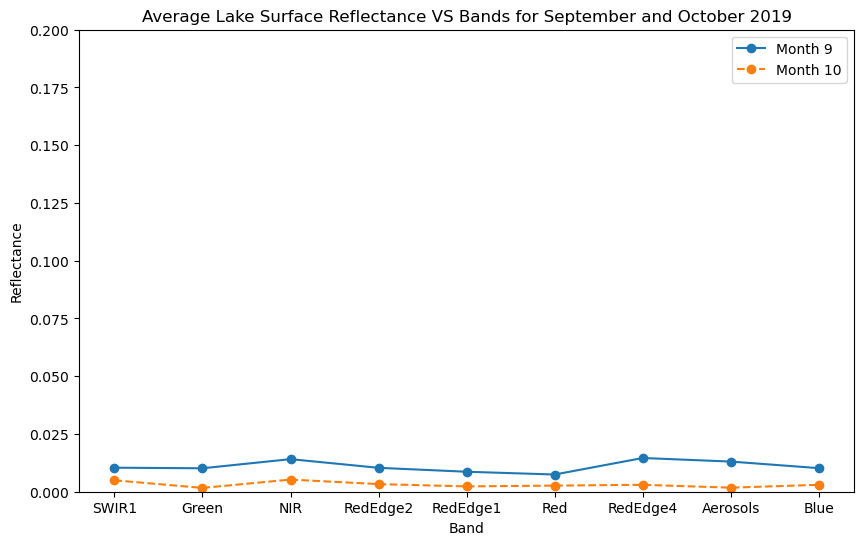

In [185]:
data_by_month = {}
monthly_average_reflectance = {}  # New dictionary to store average reflectance values

for index, row in df_s2_reflectance.iterrows():
    date = row['date']
    reflectance = row['reflectance']
    
    year = date.year
    
    if year == 2019:
        month = date.month
        
        if month in [9, 10]:  # Only consider data for September (9) and October (10)
            if month not in data_by_month:
                data_by_month[month] = {'band': [], 'dates': [], 'reflectance': []}
            
            if reflectance:
                for band in STD_NAMES:
                    value = reflectance.get(band)
                    if value is not None:
                        value /= 10000  # Divide by 10000 to convert from DN to reflectance
                        data_by_month[month]['band'].append(band)
                        data_by_month[month]['dates'].append(date)
                        data_by_month[month]['reflectance'].append(value)

# Calculate the average reflectance for each band for each month
for month, data in data_by_month.items():
    unique_bands = list(set(data['band']))
    average_reflectance = []
    for band in unique_bands:
        indices = [i for i, b in enumerate(data['band']) if b == band]
        reflectance_values = [data['reflectance'][i] for i in indices]
        avg_reflectance = sum(reflectance_values) / len(reflectance_values)
        average_reflectance.append(avg_reflectance)
    monthly_average_reflectance[month] = {'band': unique_bands, 'reflectance': average_reflectance}

plt.figure(figsize=(10, 6))

line_styles = ['-', '--', '-.', ':']  # List of line styles
num_styles = len(line_styles)
style_index = 0

for month, data in monthly_average_reflectance.items():
    line_style = line_styles[style_index % num_styles]  # Cycle through line styles
    plt.plot(data['band'], data['reflectance'], linestyle=line_style, marker='o', label=f"Month {month}")
    
    style_index += 1

plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.ylim(0, 0.2)  # Adjust the y-axis limit based on the reflectance range
plt.title('Average Lake Surface Reflectance VS Bands for September and October 2019')
plt.legend()
plt.show()


# DOC

In [186]:
import pandas as pd

# Read the data from the Excel file
data_doc = pd.read_excel('/Users/mindsmatter/Desktop/Lakes/LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L', 'SITE_ID', 'DATE_SMP'])

data_doc = data_doc[data_doc['DOC_MG_L'].notnull()]

# Sort the DataFrame by 'DATE_SMP' column in ascending order
data_doc = data_doc.sort_values(by='DATE_SMP')

# Select the 'DATE_SMP' and 'DOC_MG_L' columns and filter by specific_site_id
specific_site_id = '1A1-103'  # BIG_MOOSE_LAKE
data = data_doc[data_doc['SITE_ID'] == specific_site_id][['DATE_SMP', 'DOC_MG_L','SITE_ID']].rename(columns={'DATE_SMP': 'Date', 'DOC_MG_L': 'DOC'})

# Filter the data for the year 2019
data_2019 = data[data['Date'].dt.year == 2019]

# Set the display options to expand all rows
# Use the pd.options.display context manager to show all rows
with pd.option_context('display.max_rows', None):
    print(data_2019)


            Date       DOC  SITE_ID
18861 2019-02-05  7.659300  1A1-103
38335 2019-04-02  6.400300  1A1-103
37120 2019-05-01  5.958300  1A1-103
16544 2019-07-09  5.888300  1A1-103
1887  2019-09-04  5.505700  1A1-103
38346 2019-11-14  7.429081  1A1-103


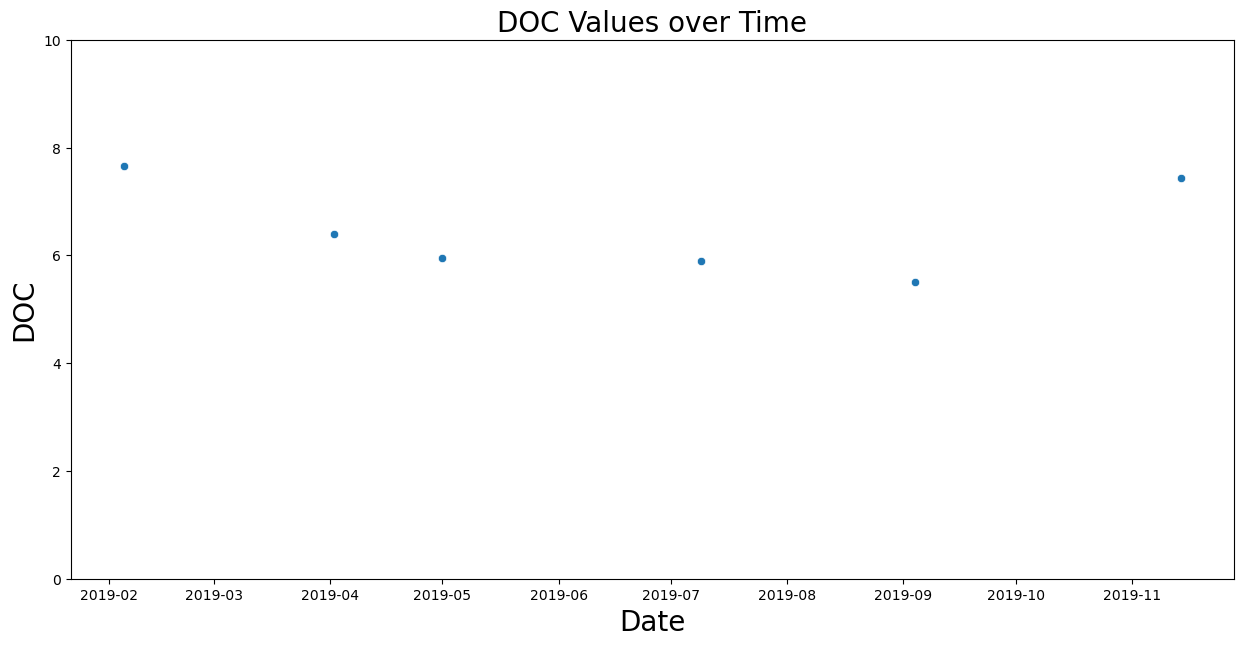

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=data_2019, x='Date', y='DOC', ax=ax)

# Set the labels and title
ax.set_ylabel('DOC', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.set_title('DOC Values over Time', fontsize=20)
ax.set_ylim(0, 10)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()


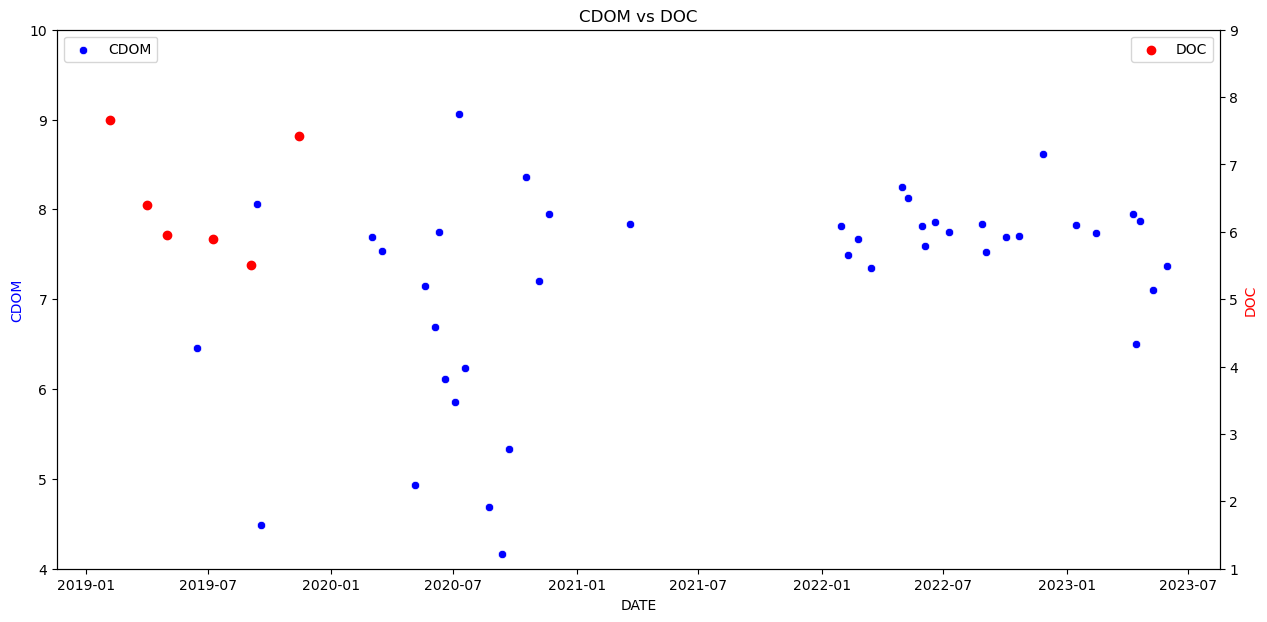

In [192]:
# CDOM vs DOC Scatterplot 
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for CDOM
sns.scatterplot(data=df, x='date', y='CDOM', ax=ax, label='CDOM', color='blue')

# Create a twin Axes object for DOC
ax2 = ax.twinx()

# Matplotlib scatter plot for DOC
ax2.scatter(data_2019['Date'], data_2019['DOC'], label='DOC', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('CDOM', color='blue')
ax2.set_ylabel('DOC', color='red')
ax.set_title('CDOM vs DOC')

# Set different ranges for the y-axes
ax.set_ylim(4,10)  # Adjust the range for CDOM
ax2.set_ylim(1, 9)  # Adjust the range for DOC

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()